# Trabajo 1 - Grupo 6  

**Curso:** INTRODUCCIÓN A CIENCIA DE DATOS Y MACHINE LEARNING CON PYTHON  
**Profesor:** Luis Zapata Bobadilla  

---

## Integrantes
- Carmen Crisanto, César Jair  
- Miranda Sanchez, Alex Abraham Patrick  
- Prado Chafloque, Sarai Elizabeth  
- Reategui Zapata, Joaquin Alejandro  

---

## Pregunta de investigación
**¿Cómo influye el déficit fiscal en las expectativas empresariales de corto plazo (3 meses) y largo plazo (12 meses), y cuál es el rol de la tasa de referencia del BCRP como mecanismo de transmisión?**  

## Marco Teórico

En este análisis trabajamos con cuatro variables macroeconómicas claves:

- **Expectativas de inflación (3 meses y 12 meses):**  
  Representan las percepciones de hogares y empresas sobre el nivel de precios en el corto y mediano plazo.  
  Según la teoría económica, las expectativas influyen en la fijación de salarios y contratos. Además, expectativas desancladas generan mayor volatilidad e incertidumbre en la economía. Se espera que las expectativas a 3 meses respondan más rápido a shocks transitorios, mientras que las de 12 meses reflejan una visión más estable.

- **Tasa de interés de referencia:**  
  Es el principal instrumento de política monetaria del banco central. Una reducción busca estimular el crédito y la demanda, mientras que un aumento pretende contener presiones inflacionarias.  
  Teóricamente, una política monetaria más restrictiva debería contribuir a reducir expectativas de inflación.

- **Déficit fiscal:**  
  Expresa la diferencia entre ingresos y gastos del sector público. Un déficit elevado y persistente puede generar presiones sobre tasas de interés y expectativas de inflación, pues implica mayor financiamiento del Estado y riesgo de sostenibilidad fiscal.

**En resumen:** estas variables son relevantes porque muestran cómo interactúan la política fiscal, la política monetaria y las expectativas de los agentes económicos. En periodos de crisis (como la pandemia de 2020 o shocks recientes), la teoría anticipa que estas relaciones pueden alterarse, generando outliers o rupturas en las tendencias.

### Consolidación de las Series de Datos

En esta primera etapa cargaremos y unificaremos las series de interés económico que se trabajarán a lo largo del análisis:  
- **Expectativas de la economía a 12 meses**  
- **Expectativas de la economía a 3 meses**  
- **Tasa de referencia (%)**  
- **Déficit fiscal (% del PBI, 12 meses móviles)**  

Cada archivo contiene la información en formato Excel, con meses expresados como `Ene15`, `Jul-24` o similares. Para poder analizarlos, se construye una función que traduce esos periodos en fechas estándar (AAA-MM-DD) y luego se fusionan todas las series en un solo dataset.  

El objetivo de este bloque es **construir una base limpia y consolidada**, que servirá como insumo para los gráficos y el análisis descriptivo posterior.


In [3]:
import pandas as pd
import re
from pathlib import Path

# Ruta Base
BASE = r"C:\Users\DREP\Desktop\ICD"

# Archivos y nombres de columna destino
files = {
    "Expectativas_12m": Path(BASE, "Expectativas de la economía a 12 meses.xlsx"),
    "Expectativas_3m":  Path(BASE, "Expectativas de la economía a 3 meses.xlsx"),
    "Tasa_Referencia":  Path(BASE, "Tasa de Interes de Referencia.xlsx"),
    "Deficit_Fiscal":   Path(BASE, "Déficit Fiscal.xlsx"),
}

# Periodos tipo 'Ene15', 'Jul-24', 'Abr 2025' -> Timestamp (YYYY-MM-01)
M = {'ene':1,'feb':2,'mar':3,'abr':4,'may':5,'jun':6,'jul':7,'ago':8,'set':9,'sep':9,'oct':10,'nov':11,'dic':12}
def parse_period(x):
    if not isinstance(x, str): x = str(x)
    t = re.sub(r'[\.\s-]+', '', x.strip().lower())
    if len(t) < 4: return pd.NaT
    m, y = t[:3], t[3:]
    if not y.isdigit() or m not in M: return pd.NaT
    y = int(y); y = (2000+y) if y < 100 else y
    return pd.Timestamp(year=y, month=M[m], day=1)

# Leer hoja "Mensuales":
def load_series(xlsx_path, colname):
    sheet = "Mensuales"  # en estos archivos existe
    raw = pd.read_excel(xlsx_path, sheet_name=sheet, header=None)
    df = raw.dropna(how="all").iloc[:, :2].copy()
    # si las dos primeras filas son metadatos (strings), saltarlas
    if len(df) >= 3 and isinstance(df.iloc[0,1], str) and isinstance(df.iloc[1,1], str):
        df = df.iloc[2:, :]
    df.columns = ["PeriodoRaw", colname]
    fecha = df["PeriodoRaw"].apply(parse_period)
    out = pd.DataFrame({"Fecha": fecha, colname: pd.to_numeric(df[colname], errors="coerce")})
    return out.dropna(subset=["Fecha", colname]).sort_values("Fecha").reset_index(drop=True)

# Cargar todas y unir por Fecha
series = {name: load_series(path, name) for name, path in files.items()}
df = None
for _, d in series.items():
    df = d if df is None else df.merge(d, on="Fecha", how="outer")

# Poner Fecha como índice y mostrarla como MM/AAAA
df = df.set_index("Fecha").sort_index()
df.index = df.index.strftime("%m/%Y")

# Renombrar columnas
df = df.rename(columns={
    "Expectativas_12m": "Expectativas (12m)",
    "Expectativas_3m":  "Expectativas (3m)",
    "Tasa_Referencia":  "Tasa de referencia (%)",
    "Deficit_Fiscal":   "Déficit fiscal (% PBI, 12m)"
})

# Guardar CSV
df.to_csv(Path(BASE, "series_consolidadas.csv"), encoding="utf-8-sig")

# Mostrar tabla
df.head(12)




,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
Fecha,,,,
01/2015,65.189873,54.231975,3.25,-0.269609
02/2015,60.534591,50.157729,3.25,-0.333748
03/2015,56.060606,49.388379,3.25,-0.399409
04/2015,55.539773,46.742210,3.25,-0.681990
05/2015,53.835227,45.070423,3.25,-0.871407
06/2015,55.414013,50.625000,3.25,-0.935100
07/2015,54.057592,46.719160,3.25,-0.904423
08/2015,49.262899,42.222222,3.25,-0.996294
09/2015,50.639386,43.222506,3.50,-1.332746


In [4]:
# Ver primeras filas
df.head()



,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
Fecha,,,,
01/2015,65.189873,54.231975,3.25,-0.269609
02/2015,60.534591,50.157729,3.25,-0.333748
03/2015,56.060606,49.388379,3.25,-0.399409
04/2015,55.539773,46.742210,3.25,-0.681990
05/2015,53.835227,45.070423,3.25,-0.871407



La tabla muestra los **primeros 12 meses (2015)** de las series consolidadas:

- **Expectativas (12m)** y **Expectativas (3m):** Ambas series inician en valores relativamente altos (65 y 54 en enero 2015) y muestran una caída sostenida en los meses siguientes, lo que refleja un deterioro en la confianza de los agentes económicos.  
- **Tasa de referencia (%):** Comienza en 3.25% durante la primera mitad del año y sube gradualmente hacia 3.75% en diciembre, evidenciando que el Banco Central empezó a ajustar la política monetaria en respuesta al contexto.  
- **Déficit fiscal (% del PBI, 12m):** Es negativo en todo el periodo, y además se profundiza mes a mes (de –0.27% en enero a –1.91% en diciembre), lo que indica un mayor desequilibrio fiscal.

En conjunto, lo que estamos viendo para 2015 es un **deterioro simultáneo en expectativas, un ajuste de política monetaria y un déficit fiscal creciente**, un patrón que probablemente se relacione con el contexto económico internacional desfavorable de esos años (caída de precios de commodities, menor crecimiento regional).



A continuación, mostramos las **últimas filas** del DataFrame consolidado.  
Esto nos permite identificar cuál es el periodo más reciente en el que tenemos información disponible para cada serie económica.


In [7]:
# Ver últimas filas
df.tail()

,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
Fecha,,,,
04/2025,57.903780,52.131148,4.75,-2.842568
05/2025,56.890459,53.965517,4.50,-2.630855
06/2025,56.644518,52.903226,4.50,-2.560267
07/2025,58.305648,54.545455,4.50,-2.574953
08/2025,NaN,NaN,4.50,NaN


Las últimas filas abarcan desde **abril a agosto de 2025**:

- **Expectativas (12m) y (3m):** Se mantienen en un rango de 52–58 puntos, lo que sugiere un nivel moderado de confianza. No se observa un deterioro fuerte, pero tampoco una recuperación clara.  
- **Tasa de referencia (%):** Se sitúa en 4.75% en abril y luego desciende a 4.50% desde mayo, indicando un ajuste monetario del BCRP hacia una postura ligeramente más expansiva.  
- **Déficit fiscal (% del PBI, 12m):** Continúa en negativo, aunque muestra una leve mejora: pasa de –2.84% en abril a –2.57% en julio, antes de estabilizarse. Esto podría interpretarse como un esfuerzo de consolidación fiscal.  
- **Valores faltantes en agosto 2025:** En esa fila aparecen `NaN` en expectativas y déficit, lo que probablemente se debe a que todavía no se publicaban esos indicadores al momento de extraer los datos.

En conjunto, los últimos registros sugieren un **contexto de ligera mejora fiscal y flexibilización monetaria**, en un entorno donde las expectativas aún se mantienen estables pero lejos de niveles de fuerte optimismo.



Con este paso verificamos cuántas observaciones y cuántas variables contiene el DataFrame consolidado.  
Esto es clave para confirmar la extensión de nuestra base de datos antes de continuar con análisis gráficos o econométricos.


In [10]:
# Dimensiones del DataFrame (filas, columnas)
df.shape


(128, 4)


El DataFrame tiene 128 filas (observaciones mensuales) y 4 columnas (las series económicas: expectativas a 12 meses, expectativas a 3 meses, tasa de referencia y déficit fiscal).  

Dado que la frecuencia es mensual, estas 128 observaciones equivalen a algo de 10 años de datos, lo cual nos proporciona un horizonte suficiente para analizar la evolución económica reciente, desde 2015 hasta mediados de 2025.


### Revisión de valores faltantes

En este bloque se cuentan los valores nulos (`NaN`) de cada variable.  
Este paso es esencial en todo Análisis Exploratorio de Datos (EDA), ya que la presencia de datos faltantes puede afectar los gráficos, estadísticas descriptivas o modelos econométricos posteriores.


In [13]:
df.isna().sum()

Expectativas (12m)             1
Expectativas (3m)              1
Tasa de referencia (%)         0
Déficit fiscal (% PBI, 12m)    1
dtype: int64


- **Expectativas (12m):** 1 valor faltante.  
- **Expectativas (3m):** 1 valor faltante.  
- **Tasa de referencia (%):** no presenta valores faltantes.  
- **Déficit fiscal (% PBI, 12m):** 1 valor faltante.  

Los `NaN` corresponden a observaciones recientes (como agosto 2025), en las que aún no se publicaban los datos al momento de la descarga.  
Esto confirma que el problema no es de calidad del dato, sino de **timing de publicación**, por lo que podemos proceder de dos maneras:  
1. Mantener esos `NaN` si solo hacemos análisis descriptivo.  
2. O bien eliminarlos/llenarlos si necesitamos trabajar con un panel completo para análisis econométrico.


### Eliminación de valores faltantes

En este paso eliminamos las filas que contienen `NaN` para asegurar que todas las series tengan observaciones completas.  
En nuestro caso, esto corresponde al mes de agosto 2025, en el que no estaban disponibles todas las variables.


In [16]:
# Eliminar filas con NA (esto quita agosto donde faltan valores en algunas series)
df_clean = df.dropna()

print(df_clean.tail())
print("Número de filas antes:", len(df), "| después:", len(df_clean))

         Expectativas (12m)  Expectativas (3m)  Tasa de referencia (%)  \
Fecha                                                                    
03/2025           58.075601          53.934426                    4.75   
04/2025           57.903780          52.131148                    4.75   
05/2025           56.890459          53.965517                    4.50   
06/2025           56.644518          52.903226                    4.50   
07/2025           58.305648          54.545455                    4.50   

         Déficit fiscal (% PBI, 12m)  
Fecha                                 
03/2025                    -3.279455  
04/2025                    -2.842568  
05/2025                    -2.630855  
06/2025                    -2.560267  
07/2025                    -2.574953  
Número de filas antes: 128 | después: 127



- El DataFrame pasó de 128 a 127 filas, eliminando únicamente la observación de agosto 2025.  
- Ahora tenemos una base limpia, con todas las series completas desde enero 2015 hasta julio 2025.  
- Al revisar las últimas filas (marzo a julio de 2025), confirmamos que la información clave se conserva, incluyendo la caída ligera en la tasa de referencia y la mejora parcial del déficit fiscal.  

Esto nos da un dataset más limpio para análisis estadístico, sin problemas de datos faltantes.



Con este bloque revisamos la estructura del DataFrame (`info()`) después de eliminar los valores nulos.  
Esto permite confirmar el número de observaciones, las variables disponibles, los tipos de datos y la ausencia de `NaN`.


In [19]:
# Resumen de tipos de datos y valores nulos
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 01/2015 to 07/2025
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Expectativas (12m)           127 non-null    float64
 1   Expectativas (3m)            127 non-null    float64
 2   Tasa de referencia (%)       127 non-null    float64
 3   Déficit fiscal (% PBI, 12m)  127 non-null    float64
dtypes: float64(4)
memory usage: 5.0+ KB



- El DataFrame contiene 127 observaciones (mensuales) y 4 columnas. 
- Todas las variables están en formato `float64`, lo cual es adecuado para análisis estadístico y gráficos.  
- No existen valores nulos (`non-null count = 127` en todas las columnas).  
- El índice está compuesto por las fechas en formato MM/AAAA, lo que facilita la lectura de series temporales.  

Esto confirma que ya contamos con un dataset completo, limpio y listo para análisis


### Primeras observaciones

Se muestran las primeras filas del DataFrame limpio (`df_clean.head()`), con el objetivo de verificar que las series estén correctamente estructuradas y alineadas desde el inicio del periodo de estudio.


In [22]:
df_clean.head()

,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
Fecha,,,,
01/2015,65.189873,54.231975,3.25,-0.269609
02/2015,60.534591,50.157729,3.25,-0.333748
03/2015,56.060606,49.388379,3.25,-0.399409
04/2015,55.539773,46.742210,3.25,-0.681990
05/2015,53.835227,45.070423,3.25,-0.871407



Las primeras observaciones corresponden al año **2015**:

- **Expectativas (12m):** comienzan en un nivel alto (65.2 en enero) pero muestran una tendencia descendente inmediata.  
- **Expectativas (3m):** también empiezan relativamente elevadas (54.2) y caen de forma más pronunciada en los primeros meses.  
- **Tasa de referencia (%):** estable en 3.25% durante este tramo inicial, lo que indica que aún no se habían realizado ajustes monetarios.  
- **Déficit fiscal (% del PBI, 12m):** inicia en –0.27% y se va ampliando (más negativo) a medida que avanza el año, reflejando un deterioro fiscal temprano.  

En conjunto, estas observaciones iniciales marcan el punto de partida del periodo de análisis (2015), en el que ya se percibía un deterioro en expectativas y en las cuentas fiscales, con una política monetaria que todavía permanecía estable.


In [24]:
df_clean.tail()

,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
Fecha,,,,
03/2025,58.075601,53.934426,4.75,-3.279455
04/2025,57.903780,52.131148,4.75,-2.842568
05/2025,56.890459,53.965517,4.50,-2.630855
06/2025,56.644518,52.903226,4.50,-2.560267
07/2025,58.305648,54.545455,4.50,-2.574953


### Descripción del DataFrame

El dataset contiene **127 observaciones mensuales** que van desde **enero 2015 hasta julio 2025**.  
El índice corresponde a las fechas (en formato `MM/AAAA`), lo cual permite trabajar directamente con series de tiempo.

Las **variables incluidas** son:

- **Expectativas (12m):** índice de confianza empresarial a 12 meses.  
- **Expectativas (3m):** índice de confianza empresarial a 3 meses.  
- **Tasa de referencia (%):** tasa de política monetaria fijada por el BCRP.  
- **Déficit fiscal (% PBI, 12m):** resultado fiscal acumulado en 12 meses como porcentaje del PBI.  

Todas las variables son de tipo numérico (`float64`) y **no presentan valores faltantes**, por lo que el dataset está completo y listo para análisis exploratorio y visualización.  


In [26]:
# Estadísticas descriptivas básicas (solo variables numéricas)
df_clean.describe()

,Expectativas (12m),Expectativas (3m),Tasa de referencia (%),"Déficit fiscal (% PBI, 12m)"
count,127.000000,127.000000,127.000000,127.000000
mean,58.590269,47.707358,3.753937,-2.861565
std,9.400688,9.281927,2.108887,1.704782
min,30.446928,9.137055,0.250000,-8.710662
25%,53.266344,42.648013,2.750000,-3.263601
50%,58.079268,49.500000,3.500000,-2.574953
75%,66.286230,54.160485,4.875000,-1.805760
max,77.450981,64.142860,7.750000,-0.269609




- **Expectativas empresariales:** a 12 meses se ubican en promedio por encima del umbral de optimismo (>50), mientras que a 3 meses están ligeramente por debajo, lo que refleja que los agentes económicos tienden a reaccionar con mayor pesimismo en el corto plazo.  

- **Tasa de referencia:** osciló entre un mínimo histórico de 0.25% durante la pandemia (2020, política expansiva) y un máximo de 7.75% en 2022–2023 (ciclo restrictivo por inflación), mostrando la fuerte reacción del BCRP ante distintos contextos macroeconómicos.  

- **Déficit fiscal:** promedió −2.9% del PBI, con un mínimo de −8.7% en 2020 (crisis sanitaria) y un máximo cercano al equilibrio (−0.27%), evidenciando un patrón de déficit persistente con episodios críticos en choques extraordinarios.  


### Distribución de las expectativas (12m y 3m)

En este bloque construimos histogramas para analizar la distribución de los índices de expectativas a 12 meses y 3 meses.  
Se incluye una línea de referencia en el valor 50, que es el **umbral de optimismo**:  
- Valores mayores a 50 indican expectativas optimistas.  
- Valores menores a 50 reflejan pesimismo.


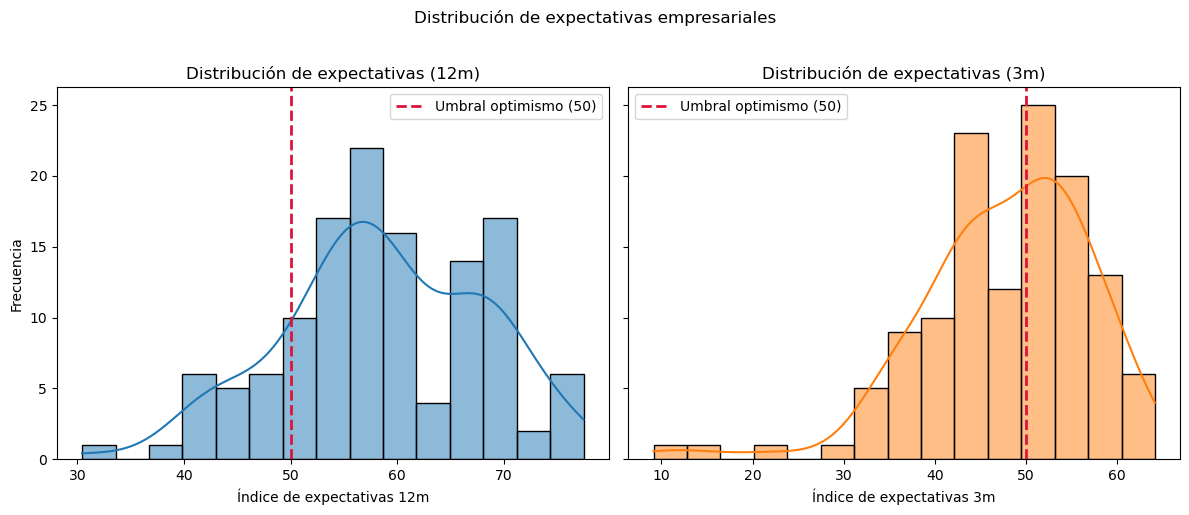

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- DataFrame base ---
df_hist = df_clean[["Expectativas (12m)", "Expectativas (3m)"]].dropna()

# --- Figura con dos histogramas lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histograma Expectativas 12m
sns.histplot(df_hist["Expectativas (12m)"], bins=15, kde=True, color="tab:blue", ax=axes[0])
axes[0].axvline(50, color="crimson", linestyle="--", linewidth=2, label="Umbral optimismo (50)")
axes[0].set_title("Distribución de expectativas (12m)")
axes[0].set_xlabel("Índice de expectativas 12m")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# Histograma Expectativas 3m
sns.histplot(df_hist["Expectativas (3m)"], bins=15, kde=True, color="tab:orange", ax=axes[1])
axes[1].axvline(50, color="crimson", linestyle="--", linewidth=2, label="Umbral optimismo (50)")
axes[1].set_title("Distribución de expectativas (3m)")
axes[1].set_xlabel("Índice de expectativas 3m")
axes[1].legend()

plt.suptitle("Distribución de expectativas empresariales", y=1.02)
plt.tight_layout()
plt.show()



- A **12 meses**, la mayor parte de las observaciones se ubica **por encima del umbral de 50**, reflejando un predominio del optimismo en el horizonte de largo plazo.  
- A **3 meses**, la distribución se concentra más cerca y por debajo del umbral, lo que indica que los empresarios tienden a mostrar **mayor pesimismo en el corto plazo**.  

En síntesis: **los agentes económicos confían más en el largo plazo, pero reaccionan con cautela en el corto plazo**.  


En este bloque tomamos la serie mensual del déficit fiscal (% del PBI, 12m) y la transformamos en un cierre anual, es decir, usamos el valor de diciembre de cada año como referencia. Luego, comparamos estos resultados con las metas fiscales establecidas por el Ministerio de Economía y Finanzas (MEF) para distintos periodos.
El objetivo es ver de manera clara en qué años el déficit fiscal se ubicó por encima o por debajo de la meta y cómo se comportó en años sin meta definida (2020 y 2021).

C:\Users\DREP\AppData\Local\Temp\ipykernel_360\3990008956.py:17: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  s = s.resample("A").last()


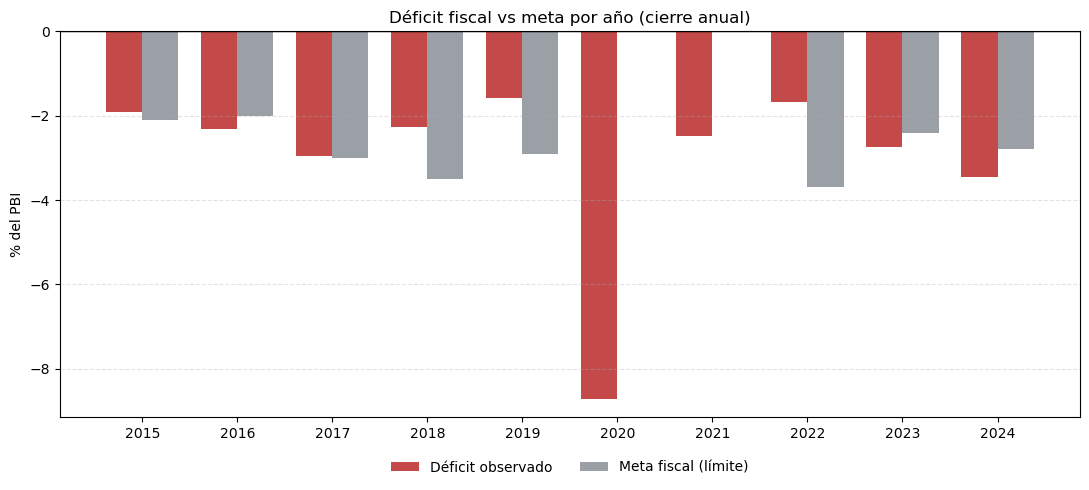

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

col_def = "Déficit fiscal (% PBI, 12m)"

dfb = df_clean.copy()

if not pd.api.types.is_datetime64_any_dtype(dfb.index):
    dfb.index = pd.to_datetime(dfb.index, format="%m/%Y")

dfb = dfb.sort_index()
dfb[col_def] = pd.to_numeric(dfb[col_def], errors="coerce")

# --- Déficit fiscal (cierre anual) ---
def cierre_anual(s: pd.Series) -> pd.Series:
    s = s.resample("A").last()
    s.index = s.index.year
    return s

deficit_cierre = cierre_anual(dfb[col_def])
deficit_cierre = deficit_cierre[deficit_cierre.index < 2025]

# --- Metas fiscales ---
metas = {
    2015:-2.1, 2016:-2.0, 2017:-3.0, 2018:-3.5, 2019:-2.9,
    2020:None, 2021:None, 2022:-3.7, 2023:-2.4, 2024:-2.8
}
meta_series = pd.Series(metas, dtype="float").reindex(deficit_cierre.index)

# --- DataFrame comparativo ---
df_comp = pd.DataFrame({
    "Déficit observado": deficit_cierre,
    "Meta fiscal": meta_series
})

# --- Gráfico ---
years = df_comp.index.values
x = np.arange(len(years))
w = 0.38

fig, ax = plt.subplots(figsize=(11,5))
ax.bar(x - w/2, df_comp["Déficit observado"], width=w, label="Déficit observado", color="#c44949")
ax.bar(x + w/2, df_comp["Meta fiscal"],      width=w, label="Meta fiscal (límite)", color="#9aa0a6")

ax.axhline(0, color="black", linewidth=1)
ax.set_xticks(x, years)
ax.set_ylabel("% del PBI")
ax.set_title("Déficit fiscal vs meta por año (cierre anual)")
ax.grid(axis="y", linestyle="--", alpha=0.35)

# Leyenda debajo del gráfico
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False)

plt.tight_layout()
plt.show()




El Perú es uno de los países de América Latina con **menor déficit fiscal en promedio**, lo que refleja un buen control de las cuentas públicas. Esto ha sido posible gracias al **sistema de metas fiscales**, que establece límites anuales para garantizar la sostenibilidad.  

No obstante, el gráfico muestra que estas metas **no se han cumplido en los últimos años**, con especial énfasis en **2024**, cuando el déficit observado superó nuevamente el límite fijado.  

Cabe señalar que en **2020 y 2021 hubo excepciones debido a la pandemia**, en las cuales se permitió un mayor gasto público para atender la emergencia sanitaria y mitigar los efectos económicos de la crisis.  



### Evolución conjunta de las principales series macroeconómicas (BCRP)

En este bloque construiremos un gráfico con tres paneles que muestre la evolución mensual de:
- **Déficit fiscal (% del PBI, 12m)**
- **Expectativas empresariales (3m y 12m)**
- **Tasa de referencia (%)**

El objetivo es observar en paralelo cómo se relacionan las expectativas de los agentes, la política monetaria y el resultado fiscal en el tiempo.  
La línea horizontal en 50 en las expectativas marca la frontera entre pesimismo (<50) y optimismo (>50).
"""


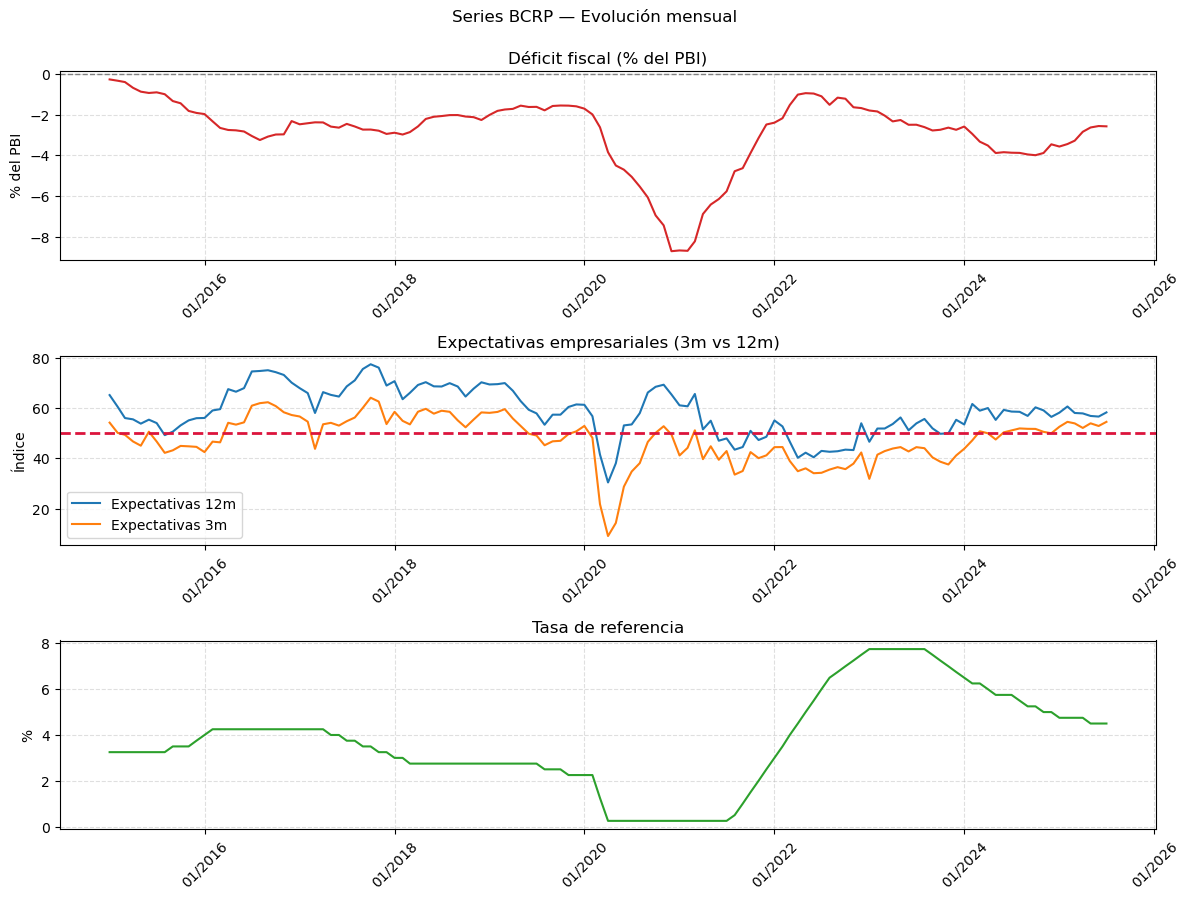

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Preparar DataFrame para graficar ---
df_plot = df_clean.copy()
if isinstance(df_plot.index[0], str):  # por si el índice es texto tipo "MM/AAAA"
    df_plot.index = pd.to_datetime(df_plot.index, format="%m/%Y")

col_e12 = "Expectativas_12m" if "Expectativas_12m" in df_plot.columns else "Expectativas (12m)"
col_e3  = "Expectativas_3m"  if "Expectativas_3m"  in df_plot.columns else "Expectativas (3m)"
col_tir = "Tasa_Referencia"  if "Tasa_Referencia"  in df_plot.columns else "Tasa de referencia (%)"
col_def = "Deficit_Fiscal"   if "Deficit_Fiscal"   in df_plot.columns else "Déficit fiscal (% PBI, 12m)"

# --- Figura con 3 paneles ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))  # sin sharex

# Panel 1: Déficit fiscal
axes[0].plot(df_plot.index, df_plot[col_def], color="tab:red")
axes[0].axhline(0, linewidth=1, color="gray", linestyle="--")
axes[0].set_title("Déficit fiscal (% del PBI)")
axes[0].set_ylabel("% del PBI")

# Panel 2: Expectativas 3m vs 12m
axes[1].plot(df_plot.index, df_plot[col_e12], color="tab:blue", label="Expectativas 12m")
axes[1].plot(df_plot.index, df_plot[col_e3],  color="tab:orange", label="Expectativas 3m")
axes[1].axhline(50, color="crimson", linestyle="--", linewidth=2)  # línea de referencia optimismo/pesimismo
axes[1].set_title("Expectativas empresariales (3m vs 12m)")
axes[1].set_ylabel("Índice")
axes[1].legend()

# Panel 3: Tasa de referencia
axes[2].plot(df_plot.index, df_plot[col_tir], color="tab:green")
axes[2].set_title("Tasa de referencia")
axes[2].set_ylabel("%")

# --- Formato de fechas y grillas ---
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.grid(True, which="major", linestyle="--", alpha=0.4)

fig.suptitle("Series BCRP — Evolución mensual", y=0.995)
fig.tight_layout()
plt.show()




- **Déficit fiscal:** la caída abrupta en 2020 refleja la política fiscal expansiva aplicada durante la pandemia, con un déficit cercano al –9% del PBI. A partir de 2021 se observa una corrección, aunque el déficit se mantiene en terreno negativo.

- **Expectativas empresariales:** las de corto plazo (3m) reaccionan con mayor volatilidad, cayendo muy por debajo del umbral de 50 durante la crisis sanitaria, lo que refleja pesimismo generalizado. Las expectativas de 12m, aunque también se deterioran, muestran más resiliencia y se recuperan antes, indicando confianza en el mediano plazo.

- **Tasa de referencia:** el Banco Central respondió reduciendo agresivamente la tasa de referencia en 2020 para estimular la economía. Posteriormente, entre 2021 y 2023, se evidencia un ciclo de alzas con el objetivo de contener la inflación, estabilizándose luego en niveles intermedios.

**En conjunto:** las tres series capturan la interacción entre política fiscal, política monetaria y percepciones empresariales frente a shocks. En 2020 se observa un “punto de quiebre” claro, donde la caída simultánea del déficit, las expectativas y la tasa de interés evidencian la magnitud de la crisis.
"""


En este bloque vamos a calcular y visualizar las **correlaciones** entre las principales variables: 
expectativas empresariales (3m y 12m), tasa de referencia y déficit fiscal. 
Se trabajan dos muestras: 
- **Muestra completa (2015–2025)** para ver la relación general de largo plazo.  
- **Submuestra 2023–2025**, que permite analizar si las correlaciones han cambiado en el contexto reciente.



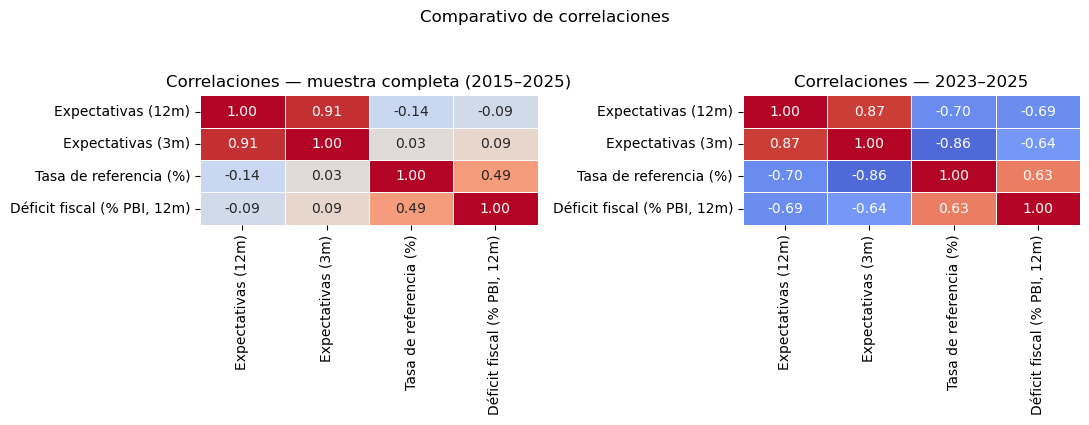

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preparar DataFrame base para correlaciones ---
df_plot = df_clean.copy()

if isinstance(df_plot.index[0], str):
    df_plot.index = pd.to_datetime(df_plot.index, format="%m/%Y")

col_e12 = "Expectativas_12m" if "Expectativas_12m" in df_plot.columns else "Expectativas (12m)"
col_e3  = "Expectativas_3m"  if "Expectativas_3m"  in df_plot.columns else "Expectativas (3m)"
col_tir = "Tasa_Referencia"  if "Tasa_Referencia"  in df_plot.columns else "Tasa de referencia (%)"
col_def = "Deficit_Fiscal"   if "Deficit_Fiscal"   in df_plot.columns else "Déficit fiscal (% PBI, 12m)"
cols = [col_e12, col_e3, col_tir, col_def]

# --- Submuestras ---
df_full   = df_plot[cols].dropna()
df_2325   = df_plot.loc["2023":"2025", cols].dropna()

corr_full = df_full.corr()
corr_2325 = df_2325.corr()

# --- Heatmaps lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

sns.heatmap(corr_full, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar=False, ax=axes[0])
axes[0].set_title("Correlaciones — muestra completa (2015–2025)")

sns.heatmap(corr_2325, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar=False, ax=axes[1])
axes[1].set_title("Correlaciones — 2023–2025")

fig.suptitle("Comparativo de correlaciones", y=1.05)
plt.tight_layout()
plt.show()



### Interpretación del comparativo de correlaciones

- En el periodo completo (2015–2025), las correlaciones son en general **débiles**, salvo la alta relación entre expectativas de 3 y 12 meses.  
- En cambio, durante 2023–2025 las correlaciones se intensifican: el **déficit fiscal se asocia negativamente con las expectativas** y positivamente con la tasa de referencia, mientras que la **tasa de referencia y las expectativas muestran una relación inversa**.  
- Esto sugiere que en los últimos años de incumplimiento fiscal, la interacción entre política fiscal, política monetaria y expectativas empresariales se volvió **más marcada**.  

### Lógica económica detrás de estas relaciones

Un **mayor déficit fiscal** implica más gasto público y, por tanto, mayores presiones sobre la demanda y los precios. Ojo, el único objetivo del BCRP es controlar la inflación, no reacciona como tal al mayor gasto público, es únicamente si esto trae riesgo inflacionario.
El **BCRP responde subiendo la tasa de referencia** para contener estas presiones inflacionarias.  
Finalmente, un **aumento en la tasa de interés encarece el crédito y reduce la inversión privada**, lo que deteriora las **expectativas empresariales** en el corto y largo plazo.  

En síntesis: **déficit fiscal elevado → política monetaria más restrictiva → menor optimismo empresarial**.  


A continuación, cargaremos la base de datos de salarios y graficaremos su distribución con un histograma.  
El objetivo es identificar si los salarios presentan sesgo hacia la derecha o hacia la izquierda.



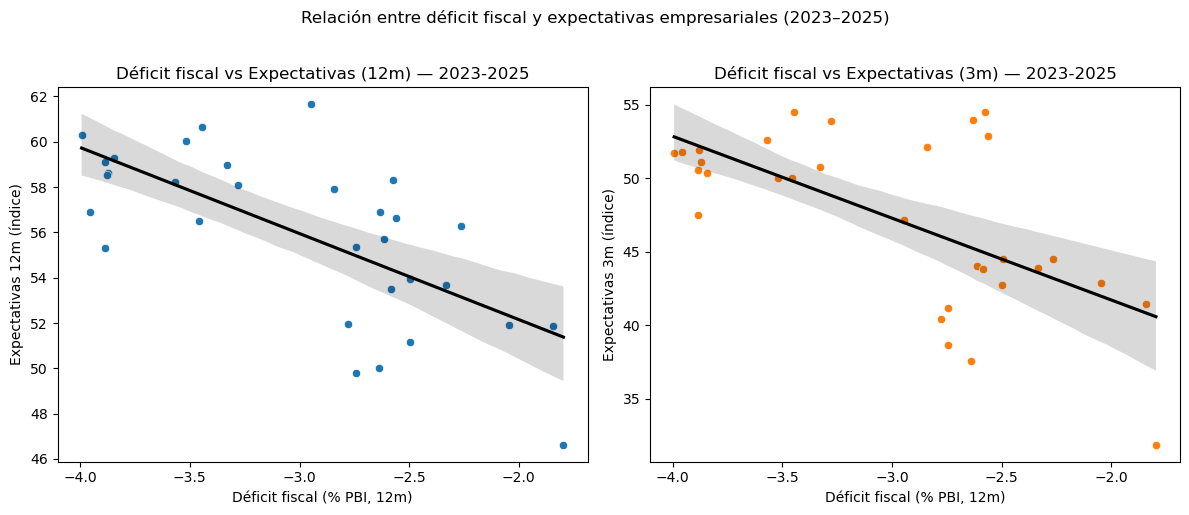

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Filtrar datos 2023-2025 ---
df_recent = df_plot.loc["2023":"2025", [col_def, col_e12, col_e3]].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Déficit fiscal vs Expectativas 12m (2023-2025)
sns.scatterplot(
    x=col_def, y=col_e12, data=df_recent,
    ax=axes[0], color="tab:blue"
)
sns.regplot(
    x=col_def, y=col_e12, data=df_recent,
    ax=axes[0], scatter=False, color="black"
)
axes[0].set_title("Déficit fiscal vs Expectativas (12m) — 2023-2025")
axes[0].set_xlabel("Déficit fiscal (% PBI, 12m)")
axes[0].set_ylabel("Expectativas 12m (índice)")

# 2. Déficit fiscal vs Expectativas 3m (2023-2025)
sns.scatterplot(
    x=col_def, y=col_e3, data=df_recent,
    ax=axes[1], color="tab:orange"
)
sns.regplot(
    x=col_def, y=col_e3, data=df_recent,
    ax=axes[1], scatter=False, color="black"
)
axes[1].set_title("Déficit fiscal vs Expectativas (3m) — 2023-2025")
axes[1].set_xlabel("Déficit fiscal (% PBI, 12m)")
axes[1].set_ylabel("Expectativas 3m (índice)")

plt.suptitle("Relación entre déficit fiscal y expectativas empresariales (2023–2025)", y=1.02)
plt.tight_layout()
plt.show()




En ambos gráficos se observa una relación negativa clara entre el déficit fiscal (medido como % del PBI) y las expectativas empresariales.  

- **Panel izquierdo (Expectativas a 12 meses):** A medida que el déficit fiscal se reduce (más cercano a -2 % del PBI), las expectativas empresariales a 12 meses también tienden a caer, lo que sugiere que una menor expansión fiscal no necesariamente es percibida como una señal positiva para el futuro.  
- **Panel derecho (Expectativas a 3 meses):** La relación negativa es incluso más pronunciada en el corto plazo. Esto indica que los empresarios ajustan sus percepciones de manera más sensible e inmediata cuando el espacio fiscal se estrecha.  

En resumen, los resultados sugieren que una política fiscal más restrictiva se asocia con un deterioro en las expectativas empresariales, tanto en el horizonte de un año como en el de tres meses, aunque el impacto parece ser más fuerte en el corto plazo.



En este bloque de código se construye un gráfico de doble eje para analizar la evolución conjunta del déficit fiscal (% del PBI, acumulado en 12 meses) y la tasa de referencia del banco central en el periodo 2015–2025.  

- En el eje **izquierdo (rojo)** se representa el déficit fiscal, que refleja la posición de las cuentas públicas.  
- En el eje **derecho (azul)** se grafica la tasa de referencia, utilizada como principal instrumento de política monetaria.  
- Además, se incluye una línea horizontal en cero para distinguir con claridad cuándo el déficit fiscal desaparece o se acerca al equilibrio.  

El objetivo es observar cómo se han movido ambas variables a lo largo del tiempo y detectar si existen patrones o respuestas de la política monetaria frente a cambios en la política fiscal.  


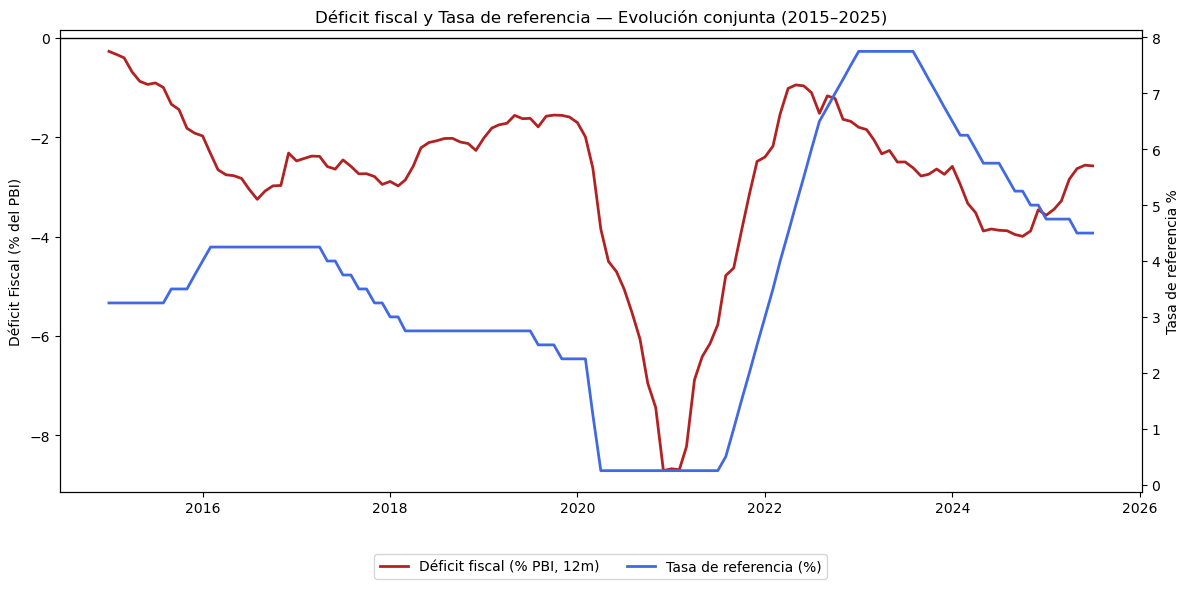

In [44]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Déficit fiscal
ax1.plot(df_plot.index, df_plot[col_def], color="firebrick", linewidth=2, label="Déficit fiscal (% PBI, 12m)")
ax1.set_ylabel("Déficit Fiscal (% del PBI)", color="black")
ax1.axhline(0, color="black", linewidth=1, linestyle="-")
ax1.tick_params(axis="y", labelcolor="black")

# Tasa de referencia
ax2 = ax1.twinx()
ax2.plot(df_plot.index, df_plot[col_tir], color="royalblue", linewidth=2, label="Tasa de referencia (%)")
ax2.set_ylabel("Tasa de referencia %", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Leyendas combinadas abajo
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2)

ax1.set_title("Déficit fiscal y Tasa de referencia — Evolución conjunta (2015–2025)")
fig.tight_layout()
plt.show()




El gráfico muestra la evolución conjunta del déficit fiscal y la tasa de referencia en la última década:

- **2015–2019:** El déficit fiscal se mantuvo en niveles moderados (-2 % a -3 % del PBI), mientras que la tasa de referencia osciló alrededor del 4 %–5 %. No se observa una correlación fuerte en este tramo.  
- **2020–2021 (crisis COVID-19):** El déficit fiscal se disparó hasta casi -9 % del PBI, reflejando el esfuerzo fiscal expansivo para mitigar los efectos de la pandemia. Paralelamente, la tasa de referencia se redujo a 0.25 %, el mínimo histórico, como parte de la respuesta monetaria expansiva.  
- **2022–2023:** Se produce un ajuste simultáneo: el déficit fiscal se reduce de forma abrupta y la tasa de referencia sube con fuerza hasta 8 %. Esto refleja un endurecimiento tanto fiscal como monetario frente al sobrecalentamiento y a la inflación post-pandemia.  
- **2024–2025:** Se observa una moderación en ambos frentes: el déficit fiscal vuelve a ampliarse ligeramente, mientras que la tasa de referencia empieza a descender, señal de que la política monetaria busca acompañar la normalización de la actividad.

En conjunto, los datos revelan que los momentos de crisis y recuperación han generado respuestas conjuntas de política fiscal y monetaria, donde ambos instrumentos se alinearon (expansivos en 2020–2021 y contractivos en 2022–2023). Esto resalta la importancia de la coordinación entre política fiscal y monetaria en períodos de shocks económicos.


## Uso de APIs (BCRPData)

Para este trabajo, tenemos cuatro series mensuales muy relevantes para la economía peruana desde enero de 2015 hasta el último dato disponible, todas obtenidas del Banco Central de Reserva del Perú (BCRP):

- Déficit Fiscal: Código PN39524FM
- Expectativas de inflación a 3 meses: Código PD38045AM
- Expectativas de inflación a 12 meses: Código PD37981AM
- Tasa de interés de referencia: Código PD04722MM



En este bloque de código realizamos la conexión con el API del Banco Central de Reserva del Perú (BCRP) para descargar cuatro series de interés entre enero de 2015 y diciembre de 2025:  

1. **Tasa de referencia** (instrumento clave de la política monetaria).  
2. **Expectativas empresariales a 3 meses**.  
3. **Expectativas empresariales a 12 meses**.  
4. **Déficit fiscal (% del PBI, acumulado en 12 meses)**.  

Se configura la consulta en formato `json` y se define el rango temporal. Luego se construye la URL de la API y se envía una solicitud con `requests.get()`.  

El código finalmente imprime un mensaje de confirmación si la conexión fue exitosa o, en caso contrario, muestra el error correspondiente.  

El objetivo de este paso es obtener los datos directamente desde la fuente oficial para asegurar su actualización y fiabilidad antes de iniciar el análisis exploratorio y la visualización.  

In [48]:

import requests
import pandas as pd
import numpy as np

codigos = 'PD04722MM-PD38045AM-PD37981AM-PN39524FM'

nombres = ['Tasa Referencia', 'Expectativas 3m', 'Expectativas 12m', 'Deficit Fiscal']


formato = 'json'
periodo_inicial = '2015-01'
periodo_final = '2025-12'


url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigos}/{formato}/{periodo_inicial}/{periodo_final}"
response = requests.get(url)

if response.status_code == 200:
    print("¡Conexión exitosa con el API del BCRP!")

    data = response.json()
else:
    print(f"Error al conectar con el API. Código de estado: {response.status_code}")
    data = None

¡Conexión exitosa con el API del BCRP!



Este bloque corresponde a un **ejemplo de la estructura de datos en formato JSON** que devuelve el API del BCRP.  

- La clave `"periods"` contiene una lista de observaciones mensuales.  
- Cada observación tiene dos componentes:  
  - `"name"`: el nombre del periodo (ejemplo: `"Ene.2015"`).  
  - `"values"`: una lista con los valores de las series solicitadas para ese mes.  

En este ejemplo simplificado, solo aparecen dos meses (enero y febrero de 2015) y dos valores asociados. En la descarga real deberían figurar todos los periodos y las cuatro series seleccionadas (tasa de referencia, expectativas a 3m, expectativas a 12m y déficit fiscal).  

El propósito de este bloque es **ilustrar cómo viene estructurada la información desde la API**, para luego transformarla en un formato tabular (DataFrame de pandas) que facilite el análisis y la visualización.  

In [50]:
{
    "periods": [
        {
            "name": "Ene.2015",
            "values": [3.5, 2.1]
        },
        {
            "name": "Feb.2015",
            "values": [3.6, 2.2]
        }
    ]
}

{'periods': [{'name': 'Ene.2015', 'values': [3.5, 2.1]},
  {'name': 'Feb.2015', 'values': [3.6, 2.2]}]}

El resultado muestra que la conexión con el API del BCRP fue exitosa y que se obtuvieron los primeros datos en formato JSON.  

- Cada elemento dentro de `"periods"` corresponde a un mes específico.  
- `"name"` indica el periodo reportado (por ejemplo, `"Ene.2015"`, `"Feb.2015"`).  
- `"values"` contiene los datos numéricos asociados a las series seleccionadas.  

En este ejemplo reducido aparecen únicamente dos valores por periodo (`[3.5, 2.1]` y `[3.6, 2.2]`), lo que sugiere que solo se están devolviendo parte de las series solicitadas. En la consulta completa deberían aparecer los cuatro indicadores seleccionados (tasa de referencia, expectativas a 3 meses, expectativas a 12 meses y déficit fiscal).  



se realiza una inspección de la estructura del JSON descargado desde el API del BCRP:  

1. `data.keys()` → Permite ver las claves principales del objeto `data`. Normalmente aparecen `"config"` y `"periods"`.  
2. `data['config'].keys()` → Explora las claves dentro de la sección de configuración. Esta suele contener información sobre las series consultadas, como sus códigos y nombres.  
3. `data['config']['series']` → Muestra la lista de series incluidas en la consulta, confirmando qué indicadores se descargaron.  
4. `data['periods']` → Imprime el conjunto de observaciones mensuales, donde cada elemento contiene el `"name"` (mes y año) y la lista de `"values"` (los datos de cada serie en ese periodo).  

El propósito de este bloque es familiarizarse con la jerarquía de los datos y confirmar que la consulta al API devuelve correctamente tanto la metadata (nombres y códigos de las series) como las observaciones (valores por periodo). Esto es clave antes de pasar a la etapa de transformación en un DataFrame.  

In [53]:
print("Muestro las claves de data:")

print(data.keys())
print("Muestro la claves de configuracion")
print(data['config'].keys())
print("Muestro las series")
print(data['config']['series'])

print("Muestro periods:")
print(data['periods'])

Muestro las claves de data:
dict_keys(['config', 'periods'])
Muestro la claves de configuracion
dict_keys(['title', 'series'])
Muestro las series
[{'name': 'Tasas de interés del Banco Central de Reserva - Tasa de Referencia de la Política Monetaria', 'dec': '2'}, {'name': 'Expectativas empresariales totales - Índice de expectativas de la economía a 12 meses', 'dec': '2'}, {'name': 'Expectativas empresariales totales - Índice de expectativas de la economía a 3 meses', 'dec': '2'}, {'name': 'Operaciones del sector público no financiero (millones S/) - Resultado económico (Acumulado 12 meses - Porcentaje del PBI)', 'dec': '1'}]
Muestro periods:
[{'name': 'Ene.2015', 'values': ['3.25', '65.1898734177215', '54.2319749216301', '-0.269609212500456']}, {'name': 'Feb.2015', 'values': ['3.25', '60.5345911949686', '50.1577287066246', '-0.33374767986014']}, {'name': 'Mar.2015', 'values': ['3.25', '56.0606060606061', '49.388379204893', '-0.399409499453448']}, {'name': 'Abr.2015', 'values': ['3.25',


Lo que observamos aquí es la estructura completa de los datos descargados desde el API del BCRP:

- A nivel de **configuración (`config`)**:
  - Se listan las series consultadas, cada una con su nombre y precisión decimal (`dec`).  
  - Ejemplos:
    - **Tasa de referencia** de política monetaria.  
    - **Expectativas empresariales** (12 y 3 meses).  
    - **Déficit fiscal acumulado 12m como % del PBI**.

- A nivel de **observaciones (`periods`)**:
  - Cada entrada corresponde a un mes, desde enero de 2015 hasta 2025.  
  - Contiene un `"name"` (ej. `"Ene.2015"`) y una lista de `"values"`, que son los datos de las cuatro series en ese mes.
  - Los valores aparecen en formato **string numérico**, por lo que habrá que convertirlos a `float` más adelante.
  - Se detectan valores especiales como `"n.d."` (no disponible), que deben tratarse como `NaN` para evitar errores en cálculos o gráficos.
 
Los datos ya vienen organizados por mes y por serie, listos para transformarse en un DataFrame de Pandas con fechas en el índice y columnas para cada indicador.  
Esto confirma que podemos avanzar al procesamiento y limpieza para graficar y analizar tendencias, como la caída abrupta de la tasa de referencia en 2020 (pandemia) y los déficits fiscales más profundos en ese mismo periodo.



Aqui se hace una revisión puntual de las primeras observaciones contenidas en la clave `"periods"` del JSON.  

- `data['periods'][0]` muestra el **primer registro** (enero 2015), incluyendo:
  - `"name"` → el periodo (`"Ene.2015"`).  
  - `"values"` → la lista de datos de las series en ese mes.  

- `data['periods'][1]` muestra el segundo registro(febrero 2015) con la misma estructura.  

El objetivo es validar cómo vienen organizados los datos crudos antes de transformarlos en un `DataFrame`:  
- Confirmar que los valores están en una lista ordenada que corresponde a las series pedidas.  
- Identificar si los números vienen como texto (`str`) o ya como valores numéricos.  
- Verificar la consistencia entre periodos consecutivos.  

Este paso ayuda a diseñar correctamente el proceso de limpieza y transformación hacia un formato tabular.  


In [56]:
# Miremos los datos de los primeros dos periodos para entender la estructura
if data:
    print(data['periods'][0])
    print(data['periods'][1])

{'name': 'Ene.2015', 'values': ['3.25', '65.1898734177215', '54.2319749216301', '-0.269609212500456']}
{'name': 'Feb.2015', 'values': ['3.25', '60.5345911949686', '50.1577287066246', '-0.33374767986014']}



La inspección de los dos primeros registros confirma lo siguiente:

- **Formato temporal**:  
  La clave `"name"` almacena el periodo en formato `Mes.Año` (ejemplo: `"Ene.2015"`, `"Feb.2015"`).  
  Esto servirá como base para construir la columna de fechas en el DataFrame.

- **Valores de las series**:  
  La clave `"values"` contiene una lista ordenada de cuatro elementos que corresponden exactamente a las series solicitadas:  
  1. **Tasa de referencia** → `3.25` (en ambos meses).  
  2. **Expectativas empresariales a 3 meses** → alrededor de `65` en enero y `60.5` en febrero.  
  3. **Expectativas empresariales a 12 meses** → `54.2` en enero y `50.2` en febrero.  
  4. **Déficit fiscal (% del PBI, acumulado 12m)** → alrededor de `-0.27` y `-0.33`.

- **Tipo de dato**:  
  Los valores vienen como strings numéricos, lo que implica que deberán convertirse a `float` en la etapa de transformación.


La estructura en cada periodo incluye exactamente las cuatro series en el mismo orden.  
Esto facilita la construcción de un DataFrame con columnas bien definidas y una indexación temporal adecuada.  


En este bloque de código se transforma la estructura JSON en un DataFrame de Pandas organizado y listo para el análisis:  

In [59]:
if data:

    fechas = []
    tasa_ref =[]
    exp_3m = []
    exp_12m = []
    deficit = []

    for periodo in data['periods']:

        fechas.append(periodo['name'])

        # Tasa de referencia
        if periodo['values'][1] != 'n.d.':
            tasa_ref.append(float(periodo['values'][0]))
        else:
            tasa_ref.append(np.nan)


        # Expectativas a 3 meses
        if periodo['values'][1] != 'n.d.':
            exp_3m.append(float(periodo['values'][1]))
        else:
            exp_3m.append(np.nan)

        # Expectativas a 12 meses
        if periodo['values'][2] != 'n.d.':
            exp_12m.append(float(periodo['values'][2]))
        else:
            exp_12m.append(np.nan)

         # Deficit Fiscal
        if periodo['values'][3] != 'n.d.':
            deficit.append(float(periodo['values'][3]))
        else:
            deficit.append(np.nan)

    datos_para_df = {
        'Fecha': fechas,
        'Deficit_Fiscal': deficit,
        'Expect_3m': exp_3m,
        'Expect_12m': exp_12m,
        'Tasa_Referencia': tasa_ref
    }
df_bcrp = pd.DataFrame(datos_para_df)
display(df_bcrp.head())



,Fecha,Deficit_Fiscal,Expect_3m,Expect_12m,Tasa_Referencia
0,Ene.2015,-0.269609,65.189873,54.231975,3.25
1,Feb.2015,-0.333748,60.534591,50.157729,3.25
2,Mar.2015,-0.399409,56.060606,49.388379,3.25
3,Abr.2015,-0.681990,55.539773,46.742210,3.25
4,May.2015,-0.871407,53.835227,45.070423,3.25
